In [1]:
from PIL import Image
import bayes3d as b
import os
import numpy as np
import jax.numpy as jnp
from tqdm import tqdm
import jax

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
j.meshcat.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [3]:
f = open(os.path.join(j.utils.get_assets_dir(), f"tum/livingRoom1.gt.freiburg"),"r")
data = f.readlines()
data = [d.strip('\n') for d in data]
poses = [jnp.eye(4)]

xyzw_to_rotation_matrix = jax.jit(j.t3d.xyzw_to_rotation_matrix)
transform_from_rot_and_pos = jax.jit(j.t3d.transform_from_rot_and_pos)
for i in tqdm(range(len(data))):
    xyzq = list(map(float,data[i].split(" ")))[1:]
    pos = jnp.array([xyzq[:3]])
    rot = xyzw_to_rotation_matrix(jnp.array(xyzq[3:]))
    pose = transform_from_rot_and_pos(rot, pos)
    poses.append(pose)
poses = jnp.array(poses)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 965/965 [00:00<00:00, 1304.41it/s]


In [4]:
IDX = 0
rgbs = []
original_depths = []
for IDX in tqdm(range(len(poses))):
    depth_filename = os.path.join(j.utils.get_assets_dir(), f"tum/depth/{IDX}.png")
    rgb_filename = os.path.join(j.utils.get_assets_dir(), f"tum/rgb/{IDX}.png")
    rgbs.append(jnp.array(Image.open(rgb_filename)))
    original_depths.append(np.array(Image.open(depth_filename)) / 5000)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 966/966 [00:14<00:00, 65.19it/s]


In [43]:
original_intrinsics = j.Intrinsics(
    original_depths[0].shape[0], original_depths[1].shape[1],
    481.20, -480.00,319.50,239.50,0.001, 6.0
)
intrinsics = j.camera.scale_camera_parameters(original_intrinsics, 0.2)
depths = [j.utils.resize(d, intrinsics.height, intrinsics.width) for d in original_depths]

In [221]:
T1 = 140
point_cloud_image_1 = j.t3d.unproject_depth_jit(depths[T1], intrinsics)

T2 = 150
point_cloud_image_2 = j.t3d.unproject_depth_jit(depths[T2], intrinsics)

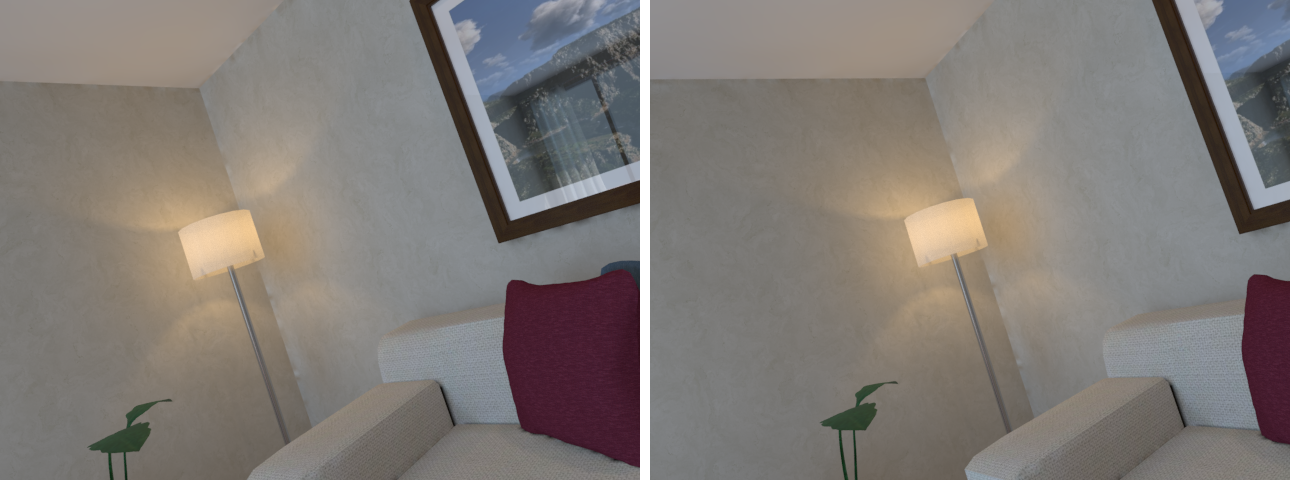

In [222]:
j.hstack_images([
    j.get_rgb_image(rgbs[T1]),
    j.get_rgb_image(rgbs[T2]),
])

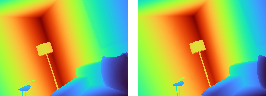

In [223]:
j.hstack_images([
    j.get_depth_image(point_cloud_image_1[:,:,2]),
    j.get_depth_image(point_cloud_image_2[:,:,2]),
])

In [224]:
mesh = j.mesh.make_voxel_mesh_from_point_cloud(point_cloud_image_1.reshape(-1,3), 0.05)

In [225]:
renderer = j.Renderer(intrinsics)
renderer.add_mesh(mesh)

Increasing frame buffer size to (width, height, depth) = (128, 96, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [226]:
j.meshcat.clear()

In [227]:
j.meshcat.clear()
j.meshcat.show_trimesh("1",mesh)

In [228]:
pose_estimate = jnp.eye(4)
NUM_SAMPLES_FOR_ESTIMATE=500
keys = jax.random.split(jax.random.PRNGKey(4), NUM_SAMPLES_FOR_ESTIMATE)
var,conc =  0.01, 1000.0
get_proposals = jax.jit(jax.vmap(lambda key,pose_estimate,var,conc: j.distributions.gaussian_vmf_sample(
    key, pose_estimate, var, conc),in_axes=(0,None,None,None)))
best_score = -jnp.inf

In [242]:
for _ in tqdm(range(10)):
    for (var,conc) in [(0.01, 2000.0),(0.001, 2000.0),(0.1, 600.0)]:
        pose_proposals = get_proposals(keys, pose_estimate, var, conc)
        keys = jax.random.split(keys[0], NUM_SAMPLES_FOR_ESTIMATE)
        rendered_images = renderer.render_parallel(pose_proposals, 0)[...,:3]
        weights = j.threedp3_likelihood_parallel_jit(point_cloud_image_2, rendered_images, 0.0001, 0.1, 1.0)
        if weights.max() > best_score:
            best_score = weights.max()
            pose_estimate = pose_proposals[weights.argmax()]
        print(best_score)

    reconstruction = renderer.render_single_object(pose_estimate, 0)[:,:,:3]

j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_image_2.reshape(-1,3))
j.meshcat.show_cloud("2", reconstruction.reshape(-1,3), color=j.RED)


  0%|                                                                                                                                                | 0/10 [00:00<?, ?it/s]

7744.698


 10%|█████████████▌                                                                                                                          | 1/10 [00:00<00:01,  4.88it/s]

7744.698
7744.698
7744.698
7744.698


 20%|███████████████████████████▏                                                                                                            | 2/10 [00:00<00:01,  4.97it/s]

7744.698
7744.698
7744.698


 30%|████████████████████████████████████████▊                                                                                               | 3/10 [00:00<00:01,  5.04it/s]

7744.698


 40%|██████████████████████████████████████████████████████▍                                                                                 | 4/10 [00:00<00:01,  5.07it/s]

7744.698
7744.698
7744.698
7744.698


 50%|████████████████████████████████████████████████████████████████████                                                                    | 5/10 [00:00<00:00,  5.08it/s]

7744.698
7744.698
7744.698
7744.698


 60%|█████████████████████████████████████████████████████████████████████████████████▌                                                      | 6/10 [00:01<00:00,  5.09it/s]

7744.698
7744.698
7744.698
7744.698


 70%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 7/10 [00:01<00:00,  5.07it/s]

7744.698
7744.698
7744.698


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 8/10 [00:01<00:00,  5.06it/s]

7744.698


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 9/10 [00:01<00:00,  5.02it/s]

7744.698
7744.698
7744.698
7744.698


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.04it/s]


7744.698


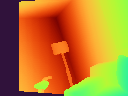

In [243]:
j.get_depth_image(renderer.render_single_object(pose_estimate, 0)[...,2])

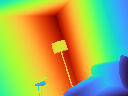

In [244]:
j.get_depth_image(point_cloud_image_2[:,:,2])

In [41]:
point_cloud_1 = j.t3d.unproject_depth_jit(depths[T1], intrinsics)
point_cloud_2 = j.t3d.unproject_depth_jit(depths[T2], intrinsics)

correction_transform = j.t3d.inverse_pose(poses[T1]) @ poses[T2]
point_cloud_2_corrected = j.t3d.apply_transform_jit(j.t3d.unproject_depth_jit(depths[T2], intrinsics),  correction_transform)

In [245]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_1.reshape(-1,3))
j.meshcat.show_cloud("2", point_cloud_2.reshape(-1,3), color=j.RED)

R = jnp.array([0.0001])
OUTLIER_PROB = 0.05
OUTLIER_VOLUME = 1.0
j.threedp3_likelihood_jit(point_cloud_1, point_cloud_2, jnp.zeros((point_cloud_2.shape[0], point_cloud_2.shape[1])), R,OUTLIER_PROB, OUTLIER_VOLUME)

TypeError: threedp3_likelihood() takes 5 positional arguments but 6 were given

In [20]:
pc = point_cloud_1.reshape(-1,3)
noise = jax.vmap(
    lambda key: jax.random.multivariate_normal(
        key, jnp.zeros(3), jnp.eye(3) * R[0]
    )
)(
    jax.random.split(jax.random.PRNGKey(3), pc.shape[0])
)
pc_noisy = pc + noise
j.meshcat.clear()
j.meshcat.show_cloud("1", pc.reshape(-1,3))
j.meshcat.show_cloud("2", pc_noisy.reshape(-1,3), color=j.RED)

In [21]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_1.reshape(-1,3))
j.meshcat.show_cloud("2", point_cloud_2_corrected.reshape(-1,3), color=j.RED)

j.meshcat.show_pose("pose", correction_transform)
j.threedp3_likelihood_jit(point_cloud_1, j.t3d.apply_transform(point_cloud_2, 
    correction_transform), jnp.zeros((point_cloud_2.shape[0], point_cloud_2.shape[1])), R,OUTLIER_PROB, OUTLIER_VOLUME)

Array(-36811.555, dtype=float32)

In [230]:
NUM_SAMPLES_FOR_ESTIMATE = 1000


In [231]:
pose_estimate = jnp.eye(4)

In [232]:
threedp3_likelihood_parallel_jit = jax.jit(jax.vmap(
    j.threedp3_likelihood,
    in_axes=(None, 0, None, None, None, None)
))


def refine_pose_estimate_inner(pose_estimate, point_cloud_1, point_cloud_2, keys, var, conc):
    keys = jax.random.split(keys[0], NUM_SAMPLES_FOR_ESTIMATE)
    pose_proposals = jax.vmap(lambda key: j.distributions.gaussian_vmf_sample(
        key, pose_estimate, var, conc))(
        keys
    )

    rendered_images = jnp.einsum(
        'aij,...j->a...i',
        pose_proposals,
        jnp.concatenate([point_cloud_2, jnp.ones(point_cloud_2.shape[:-1] + (1,))], axis=-1),
    )[..., :-1]

    best_score = j.threedp3_likelihood_jit(
        point_cloud_1, j.t3d.apply_transform(point_cloud_2, 
        pose_estimate), jnp.zeros((point_cloud_2.shape[0], point_cloud_2.shape[1])), R, OUTLIER_PROB, OUTLIER_VOLUME)
    
    weights = threedp3_likelihood_parallel_jit(
        point_cloud_1, rendered_images, jnp.zeros((point_cloud_2.shape[0], point_cloud_2.shape[1])), R,OUTLIER_PROB, OUTLIER_VOLUME)
    weights_max = weights.max()
    better = (weights_max > best_score)
    pose_estimate = pose_proposals[weights.argmax()] * better + pose_estimate* (1.0 - better)
    return pose_estimate, keys

refine_pose_estimate_jit = jax.jit(refine_pose_estimate_inner)

In [235]:
for _ in tqdm(range(20)):
    pose_estimate,keys = refine_pose_estimate_jit(pose_estimate, point_cloud_1, point_cloud_2, keys, 0.01, 1000.0)
    pose_estimate,keys = refine_pose_estimate_jit(pose_estimate, point_cloud_1, point_cloud_2, keys, 0.005, 2000.0)
    pose_estimate,keys = refine_pose_estimate_jit(pose_estimate, point_cloud_1, point_cloud_2, keys, 0.001, 1000.0)
score = j.threedp3_likelihood_jit(
    point_cloud_1, j.t3d.apply_transform(point_cloud_2, 
    pose_estimate), jnp.zeros((point_cloud_2.shape[0], point_cloud_2.shape[1])), R, OUTLIER_PROB, OUTLIER_VOLUME)
keys[0],score

In [226]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_1.reshape(-1,3))
j.meshcat.show_cloud("2", j.t3d.apply_transform(point_cloud_2, pose_estimate).reshape(-1,3), color=j.RED)

In [177]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_1.reshape(-1,3))
j.meshcat.show_cloud("2", point_cloud_2.reshape(-1,3), color=j.RED)

In [432]:
point_clouds = [
    unproject_depth(depths[t], intrinsics)
    for t in jnp.arange(200, 300, 5)
]
transforms = []
for i in tqdm(range(len(point_clouds) - 1)):
    pose_estimate = jnp.eye(4)
    point_cloud_1, point_cloud_2 = point_clouds[i], point_clouds[i+1]
    pose_estimate,keys = refine_pose_estimate_jit(pose_estimate, point_cloud_1, point_cloud_2, keys, 0.01, 1000.0)
    pose_estimate,keys = refine_pose_estimate_jit(pose_estimate, point_cloud_1, point_cloud_2, keys, 0.005, 2000.0)
    pose_estimate,keys = refine_pose_estimate_jit(pose_estimate, point_cloud_1, point_cloud_2, keys, 0.001, 1000.0)
    pose_estimate,keys = refine_pose_estimate_jit(pose_estimate, point_cloud_1, point_cloud_2, keys, 0.001, 1000.0)
    transforms.append(pose_estimate)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:22<00:00,  1.19s/it]


In [446]:
i = 15

In [450]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_clouds[i].reshape(-1,3))
j.meshcat.show_cloud("2", point_clouds[i+1].reshape(-1,3), color=j.RED)


In [451]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_clouds[i].reshape(-1,3))
j.meshcat.show_cloud("2", j.t3d.apply_transform(point_clouds[i+1], transforms[i]).reshape(-1,3), color=j.RED)


In [445]:
len(point_clouds)

20

In [30]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_1.reshape(-1,3))


In [327]:
j.meshcat.clear()
j.meshcat.show_cloud("2", j.t3d.apply_transform(point_cloud_2, pose_estimate).reshape(-1,3), color=j.RED)

In [190]:
renderer = j.Renderer(intrinsics)
renderer.add_mesh(mesh)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 96, 1024)


In [206]:
recontruction = renderer.render_single_object(j.t3d.inverse_pose(poses[T2]) @ poses[T1], 0)

In [207]:
j.meshcat.clear()
j.meshcat.show_trimesh("!", mesh)

In [143]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_1.reshape(-1,3))
j.meshcat.show_cloud("2", point_cloud_2.reshape(-1,3), color=j.RED)

In [ ]:
T_WIDTH = 0.01
translation_grid = j.make_translation_grid_enumeration(
    -T_WIDTH,-T_WIDTH,-T_WIDTH,
    T_WIDTH,T_WIDTH,T_WIDTH,
    11,11,11
)
rotation_grid = j.make_rotation_grid_enumeration(
    50, 40, -jnp.pi/40, jnp.pi/40, jnp.pi/40
)


pose_estimate = jnp.eye(4)
best_score = -1000000.0

In [ ]:
pose_proposals = jnp.einsum(
    'aij,jk->aik',
    translation_grid,
    pose_estimate,
    
)
rendered_images = jnp.einsum(
    'aij,...j->a...i',
    pose_proposals,
    jnp.concatenate([point_cloud_2, jnp.ones(point_cloud_2.shape[:-1] + (1,))], axis=-1),
)[..., :-1]

weights = j.threedp3_likelihood_parallel_jit(point_cloud_1, rendered_images, R, OUTLIER_PROB, OUTLIER_VOLUME)
weights_max = weights.max()
better = (weights_max > best_score)
pose_estimate = pose_proposals[weights.argmax()] * better + pose_estimate* (1.0 - better)
best_score = weights_max * better + best_score * (1.0 - better)
print(best_score)

pose_proposals = jnp.einsum(
    'ij,ajk->aik',
    pose_estimate,
    rotation_grid
)
rendered_images = jnp.einsum(
    'aij,...j->a...i',
    pose_proposals,
    jnp.concatenate([point_cloud_2, jnp.ones(point_cloud_2.shape[:-1] + (1,))], axis=-1),
)[..., :-1]


weights = j.threedp3_likelihood_parallel_jit(point_cloud_1, rendered_images, R, OUTLIER_PROB, OUTLIER_VOLUME)
weights_max = weights.max()
better = (weights_max > best_score)
pose_estimate = pose_proposals[weights.argmax()] * better + pose_estimate *(1.0 - better)
best_score = weights_max * better + best_score * (1.0 - better)
print(best_score)


In [93]:
j.meshcat.clear()
for i in range(1000):
    j.meshcat.show_pose(f"{i}", poses[i], size=0.01)

In [97]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_1.reshape(-1,3))


In [125]:
j.meshcat.clear()
j.meshcat.show_cloud("1", point_cloud_1.reshape(-1,3))
j.meshcat.show_cloud("2", point_cloud_2.reshape(-1,3), color=j.RED)

In [79]:
poses[1]

Array([[ 1.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  1.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  1.  , -2.25],
       [ 0.  ,  0.  ,  0.  ,  1.  ]], dtype=float32)

In [90]:
poses[100]

Array([[ 0.9232352 ,  0.25634083, -0.2862283 ,  0.0436907 ],
       [-0.25016412,  0.9664283 ,  0.05860607,  0.0111501 ],
       [ 0.2916422 ,  0.01749687,  0.95636773, -2.1024    ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]],      dtype=float32)